In [1]:
from nilmtk.utils import print_dict

# Convert data to NILMTK format and load into NILMTK

NILMTK uses an open file format based on the HDF5 binary file format to store both the power data and the metadata.  The very first step when using NILMTK is to convert your dataset to the NILMTK HDF5 file format.

## REDD

Converting the REDD dataset is easy:

In [1]:
from nilmtk.dataset_converters import convert_redd
convert_redd('/data/REDD/low_freq', '/data/REDD/redd.h5')

Loading house 1... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Loading house 2... 1 2 3 4 5 6 7 8 9 10 11 
Loading house 3... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Loading house 4... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Loading house 5... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
Loading house 6... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
Done converting YAML metadata to HDF5!
Done converting REDD to HDF5!


Now `redd.h5` holds all the REDD power data and all the relevant metadata.  In NILMTK v0.2 this conversion only uses a tiny fraction of the system memory (unlike NILMTK v0.1 which would guzzle ~1 GByte of RAM just to do the dataset conversion!).

Of course, if you want to run `convert_redd` on your own machine then you first need to download [REDD](http://redd.csail.mit.edu), decompress it and pass the relevant `source_directory` and `output_filename` to `convert_redd()`.

## Other datasets

At the time of writing, [NILMTK contains converters for 8 datasets](https://github.com/nilmtk/nilmtk/tree/master/nilmtk/dataset_converters).

Contributing a new converter is easy and highly encouraged!  [Learn how to write a dataset converter](https://github.com/nilmtk/nilmtk/blob/master/docs/manual/development_guide/writing_a_dataset_converter.md).

## Open HDF5 in NILMTK

In [5]:
from nilmtk import DataSet

redd = DataSet('/data/REDD/redd.h5')

At this point, all the metadata has been loaded into memory but none of the power data has been loaded.  This is our first encounter with a fundamental difference between NILMTK v0.1 and v0.2:  NILMTK v0.1 used to eagerly load the entire dataset into memory before you did any actual work on the data.  NILMTK v0.2 is lazy!  It won't load data into memory until you tell it what you want to do with the data (and, even then, large dataset will be loaded in chunks that fit into memory).  This allows NILMTK v0.2 to work with arbitrarily large datasets (datasets too large to fit into memory) without choking your system.

### Exploring the `DataSet` object

Let's have a quick poke around to see what's in this `redd` object...

There is a lot of metadata associated with the dataset, including information about the two models of meter device the authors used to record REDD:

In [6]:
print_dict(redd.metadata)

We also have all the buildings available as an [OrderedDict](https://docs.python.org/2/library/collections.html#collections.OrderedDict) (indexed from 1 not 0 because every dataset we are aware of starts numbering buildings from 1 not 0)

In [7]:
print_dict(redd.buildings)

Each building has a little bit of metadata associated with it (there isn't much building-specific metadata in REDD):

In [8]:
print_dict(redd.buildings[1].metadata)

Each building has an `elec` attribute which is a `MeterGroup` object (much more about those soon!)

In [9]:
redd.buildings[1].elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric 

Yup, that's where all the meat lies!

And here's a wiring diagram of the meter hierarchy:

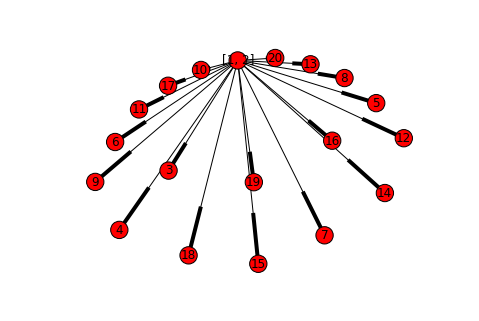

In [10]:
redd.buildings[1].elec.draw_wiring_graph()

It isn't very pretty but it shows that all the submeters are immediately downstream of the two mains meters.

Let's dive in a little deeper and tinker with `MeterGroup`...